In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primal_PINN import *
from NN_library.train_dual_PINN import *
from matplotlib.tri import Triangulation
%load_ext autoreload
%autoreload 2

Using device: cuda


In [2]:
data = dataset_grid(129, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 129**2)

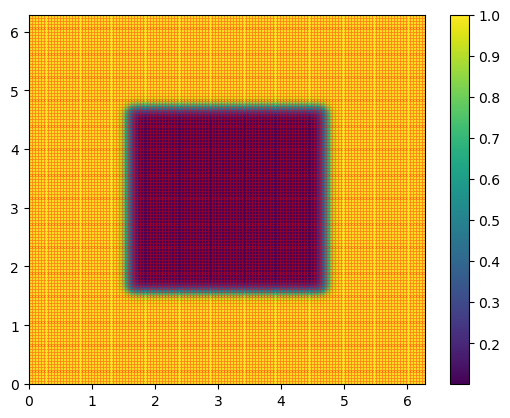

In [3]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

def a_function(x,y):
    eps = 10
    x_dir = 0.5 + 0.5*np.tanh(eps*np.sin(x-np.pi/2))
    y_dir = 0.5 + 0.5*np.tanh(eps*np.sin(y-np.pi/2))
    a = 1 - 0.9*x_dir*y_dir
    return a

def A_interp(x):  
    eps = 10
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a.view(-1,1,1) * I
    return A

def A_interp_inv(x):  
    eps = 10
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = 1/a.view(-1,1,1) * I
    return A

def A(x):  
    x = x - torch.pi/2
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1.).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def A_inv(x):  
    x = x - torch.pi/2
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1.).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = (1 / a) * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(), XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.1, c='r')

# Primal PINN

In [4]:
net_primal = PINN(n_periodic=20, n_hidden=40, n_layers=5, period_len=L)
total_params = sum(p.numel() for p in net_primal.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.00001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/PINN/square/PINN_primal_{total_params}'}

Number of parameters: 10081


In [5]:
net_primal = load_network(net_primal, args['name']+'_39999', args)
net_primal = net_primal.to(dev)

In [6]:
losses_train, losses_val = train_primal(net_primal, loaders, args, A_interp, H1, L)

Epoch: 0 mean train loss:  5.62057912e-01, bound:  7.79370487e-01
Epoch: 1 mean train loss:  5.60697794e-01, bound:  7.79326737e-01
Epoch: 2 mean train loss:  5.59345424e-01, bound:  7.79283047e-01
Epoch: 3 mean train loss:  5.58001041e-01, bound:  7.79239357e-01
Epoch: 4 mean train loss:  5.56664765e-01, bound:  7.79195786e-01
Epoch: 5 mean train loss:  5.55336714e-01, bound:  7.79152155e-01
Epoch: 6 mean train loss:  5.54016948e-01, bound:  7.79108465e-01
Epoch: 7 mean train loss:  5.52705586e-01, bound:  7.79064715e-01
Epoch: 8 mean train loss:  5.51402688e-01, bound:  7.79020965e-01
Epoch: 9 mean train loss:  5.50108254e-01, bound:  7.78977036e-01
Epoch: 10 mean train loss:  5.48822463e-01, bound:  7.78933108e-01
Epoch: 11 mean train loss:  5.47545254e-01, bound:  7.78889060e-01
Epoch: 12 mean train loss:  5.46276748e-01, bound:  7.78844953e-01
Epoch: 13 mean train loss:  5.45017123e-01, bound:  7.78800666e-01
Epoch: 14 mean train loss:  5.43766141e-01, bound:  7.78756261e-01
Epoch

In [7]:
np.save(f'NN_library/training_data/square/PINN_primal_{total_params}', np.vstack([losses_train, losses_val]))

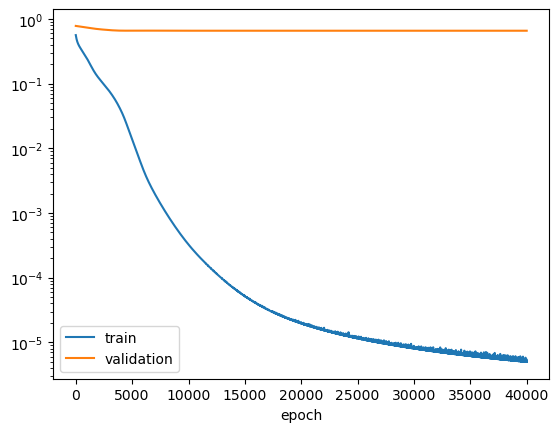

In [11]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [12]:
U1 = net_primal(grid_data).detach().cpu()
error_1, _ = PDE_loss(grid_data, net_primal, A_interp, H1)
error_2, _ = PDE_loss(grid_data, net_primal, A, H1)

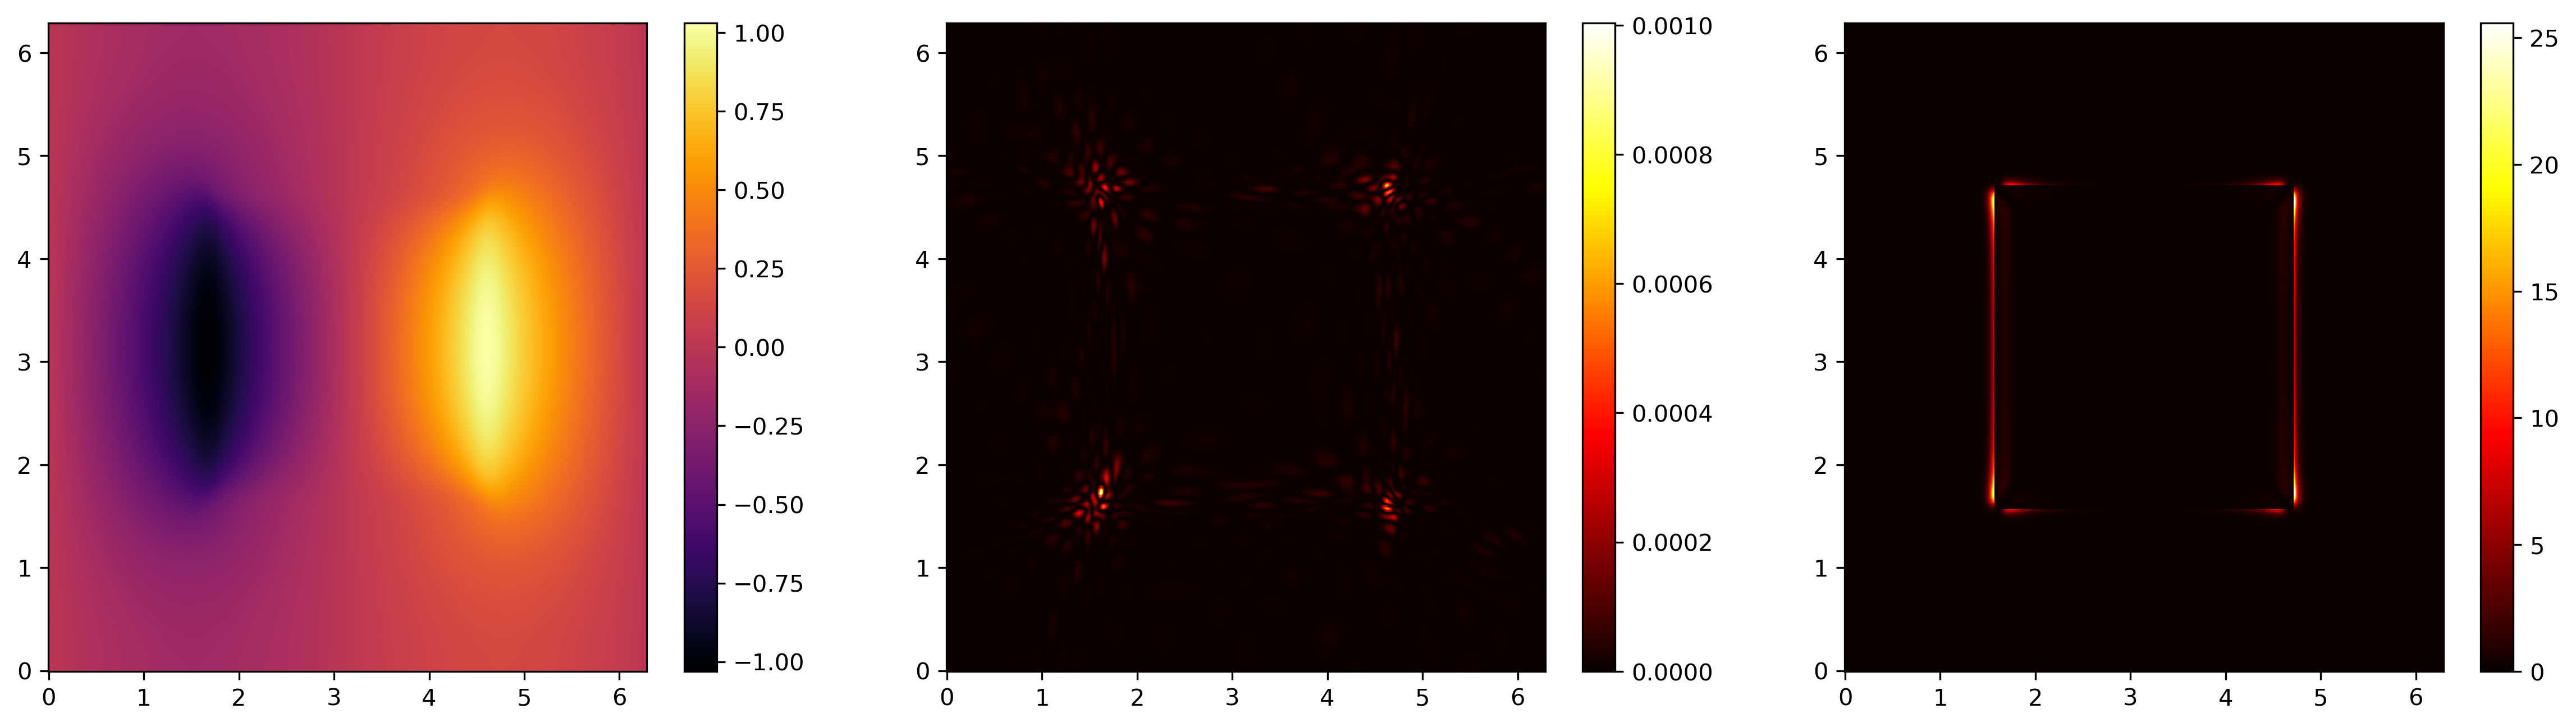

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], error_2.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos3, ax=axs[2])

In [6]:
N = 129
data = dataset_grid(N, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, N**2)

In [7]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])

_, q1 = PDE_loss(x, net_primal, A, H1)
_, q2 = PDE_loss(x, net_primal, A_interp, H1)
bound_1 = compute_bound(areas, tri, q1, L).detach()[0].item()
bound_2 = compute_bound(areas, tri, q2, L).detach()[0].item()
print(bound_1, bound_2)

np.save(f'bounds/square/A_u_PINN_{total_params}_{N}.npy', (bound_1, bound_2))

0.6547362208366394 0.6569187641143799


# Dual PINN

In [4]:
net_dual = PINN(n_periodic=20, n_hidden=40, n_layers=5, period_len=L)
total_params = sum(p.numel() for p in net_dual.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.00001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/PINN/square/PINN_dual_{total_params}'}

Number of parameters: 10081


In [6]:
net_dual = load_network(net_dual, args['name']+'_39999', args)
net_dual = net_dual.to(dev)

In [5]:
losses_train, losses_val = train_dual(net_dual, loaders, args, A_interp_inv, H1, L)

Epoch: 0 mean train loss:  4.30426407e+01, bound:  3.50740552e-01
Epoch: 1 mean train loss:  4.28929520e+01, bound:  3.50798965e-01
Epoch: 2 mean train loss:  4.27440033e+01, bound:  3.50857347e-01
Epoch: 3 mean train loss:  4.25958099e+01, bound:  3.50915581e-01
Epoch: 4 mean train loss:  4.24484024e+01, bound:  3.50973755e-01
Epoch: 5 mean train loss:  4.23017693e+01, bound:  3.51031870e-01
Epoch: 6 mean train loss:  4.21559258e+01, bound:  3.51090074e-01
Epoch: 7 mean train loss:  4.20108757e+01, bound:  3.51148307e-01
Epoch: 8 mean train loss:  4.18666306e+01, bound:  3.51206660e-01
Epoch: 9 mean train loss:  4.17231979e+01, bound:  3.51265043e-01
Epoch: 10 mean train loss:  4.15805626e+01, bound:  3.51323664e-01
Epoch: 11 mean train loss:  4.14387360e+01, bound:  3.51382315e-01
Epoch: 12 mean train loss:  4.12977219e+01, bound:  3.51441026e-01
Epoch: 13 mean train loss:  4.11575317e+01, bound:  3.51499945e-01
Epoch: 14 mean train loss:  4.10181580e+01, bound:  3.51558954e-01
Epoch

In [6]:
np.save(f'NN_library/training_data/square/PINN_dual_{total_params}', np.vstack([losses_train, losses_val]))

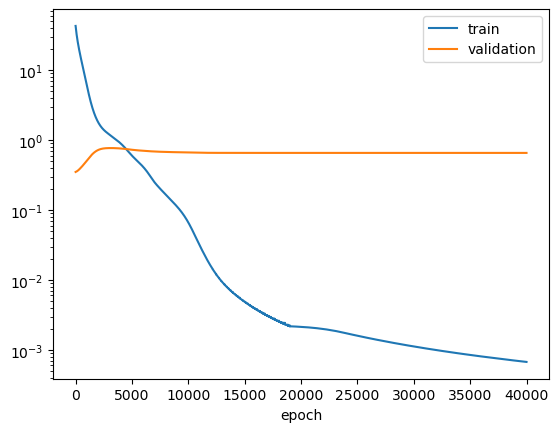

In [7]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [8]:
U2 = net_dual(grid_data).detach().cpu()
error_1, _ = PDE_loss_dual(grid_data, net_dual, A_interp_inv, H1)
error_2, _ = PDE_loss_dual(grid_data, net_dual, A_inv, H1)

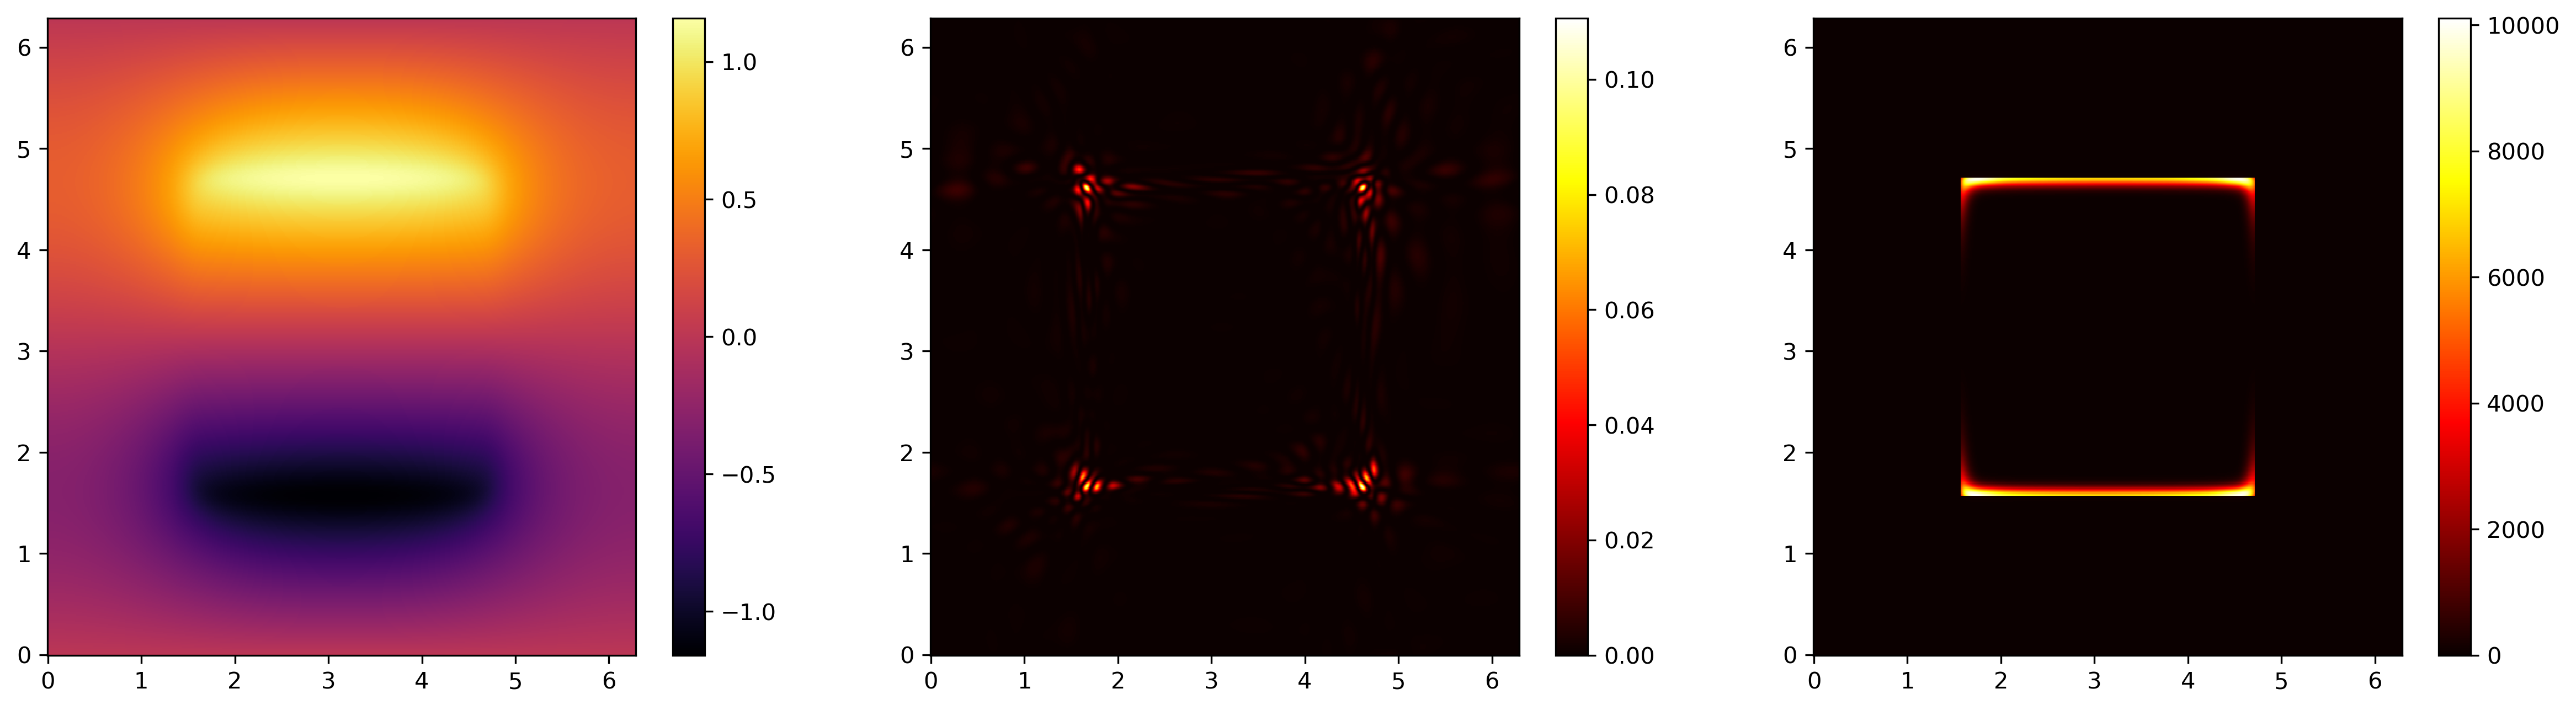

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U2.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], error_2.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos3, ax=axs[2])

In [10]:
N = 129
data = dataset_grid(N, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, N**2)

In [11]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])

_, q1 = PDE_loss_dual(x, net_dual, A_inv, H1)
_, q2 = PDE_loss_dual(x, net_dual, A_interp_inv, H1)
bound_1 = compute_bound(areas, tri, q1, L).detach()
bound_2 = compute_bound(areas, tri, q2, L).detach()
bound_inv_1 = bound_1[0] / (bound_1[0]**2 - bound_1[1]**2)
bound_inv_2 = bound_2[0] / (bound_2[0]**2 - bound_2[1]**2)

print(bound_inv_1, bound_inv_2)
np.save(f'bounds/square/A_l_PINN_{total_params}_{N}.npy', (bound_inv_1.item(), bound_inv_2.item()))

tensor(0.5981, device='cuda:0') tensor(0.6569, device='cuda:0')
